In [95]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
# Importing images

importing_data = lambda path: [np.array(Image.open(filename).resize((ims1, ims1))).ravel() for filename in glob.glob(path)]

# all
n1 = importing_data('C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
print("n1 done, size  = ", len(n1))
n2 = importing_data('C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
print("n2 done, size  = ", len(n2))
n3 = importing_data('C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
print("n3 done, size  = ", len(n3))

# hem
y1 = importing_data('C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
print("y1 done, size  = ", len(y1))
y2 = importing_data('C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
print("y2 done, size  = ", len(y2))
y3 = importing_data('C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')
print("y3 done, size  = ", len(y3))

#combining all data
train_data = (pd.DataFrame({'image': n1+n2+n3, 'label': 'Healthy'})
             .append(pd.DataFrame({'image': y1+y2+y3, 'label': 'Affected'}),
                     ignore_index=True))


n1 done, size  =  2397
n2 done, size  =  2418
n3 done, size  =  2457
y1 done, size  =  1130
y2 done, size  =  1163
y3 done, size  =  1096


/var/folders/yv/kbb9q2f16z755yyqqbfpb7b00000gn/T/ipykernel_82029/444408357.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = (pd.DataFrame({'image': n1+n2+n3, 'label': 'Healthy'})


In [97]:
# Ignoring images that are oddly shaped to avoid outliers
ims1 = 200 #desired image size

c = 1
igs = []
for i in range(len(train_data)):
    if(len(train_data.image[i])!=(3*ims1*ims1)):
#         print(c,i)
        c = c + 1
        igs.append(i)
# print(igs)
print(len(igs))

#removing outliers from the data
train_data=train_data.drop(igs,axis=0)

0


In [98]:
#seperating image from the labels in train_data
x_train = []
for tdim in train_data.image:
    x_train.append(tdim)
y_train = np.array(train_data.label)

In [99]:
#converting y_train labels to binary
y_traind = []
for i in range(len(y_train)):
    if(y_train[i]=="Healthy"):
        y_traind.append(0)
    else:
        y_traind.append(1)
print(len(y_traind))

# One hot encoding
CLASSES = 2
y_train = np.zeros([len(y_traind), CLASSES])
for i in range(len(y_traind)):
        y_train[i][y_traind[i]] = 1

10661


In [100]:
#creating an array from x_train
x_traind = np.array(x_train)

In [102]:
# splitting data for testing and training

from sklearn.model_selection import train_test_split

tts = 0.1 #portion of the data allocated for testing

x_train, x_test, y_train, y_test = train_test_split(x_traind, y_train, test_size=tts)

print('Train size: {train}, Test size: {test}'.format(train=len(x_train), test=len(x_test)))
print('Train size: {train}, Test size: {test}'.format(train=len(y_train), test=len(y_test)))

Train size: 9594, Test size: 1067
Train size: 9594, Test size: 1067


In [103]:
# Changing to Matrix format

x_train=np.matrix(x_train)
x_test=np.matrix(x_test)
y_train=np.matrix(y_train)
y_test=np.matrix(y_test)

In [104]:
# Starting to build Extreme Learning Machine(ELM) model
hu = 750

INPUT_LENGTH = x_train.shape[1]
HIDDEN_UNITS = hu #hidden units

Win = np.random.normal(size=[INPUT_LENGTH, HIDDEN_UNITS])
Win = np.matrix(Win)
print('Input Weight shape: {shape}'.format(shape=Win.shape))

Input Weight shape: (120000, 750)


In [105]:
rel = 1

def input_to_hidden(x):
    print("shape of x:",x.shape)
    print("weights shape:",Win.shape)
    a = np.dot(x, Win)
    a = np.maximum(a, rel, a) # ReLU activation
    return a


In [106]:
X = input_to_hidden(x_train)
Xt = np.transpose(X)

shape of x: (9594, 120000)
weights shape: (120000, 750)


In [107]:
# Moore-Penrose pseudo inverse

www1 = np.dot(Xt, X)

b = np.identity(len(np.array(www1)))
b = np.dot(b,3)

www1 = www1 + b
ww1 = np.linalg.inv(www1)
ww2 = np.dot(Xt, y_train)

Wout = np.dot(ww1, ww2)
print('Output weights shape: {shape}'.format(shape=Wout.shape))

Output weights shape: (750, 2)


In [108]:
def predict(x):
    x = input_to_hidden(x)
    y = np.dot(x, Wout)
    return y

In [109]:

# Prediction
y = predict(x_test)
correct = 0
total = y.shape[0]
for i in range(total):
    predicted = np.argmax(y[i])
    test = np.argmax(y_test[i])
    correct = correct + (1 if predicted == test else 0)
print('Accuracy: {:f}'.format(correct*100/total))



shape of x: (1067, 120000)
weights shape: (120000, 750)
Accuracy: 81.255858


shape of x: (1067, 120000)
weights shape: (120000, 750)


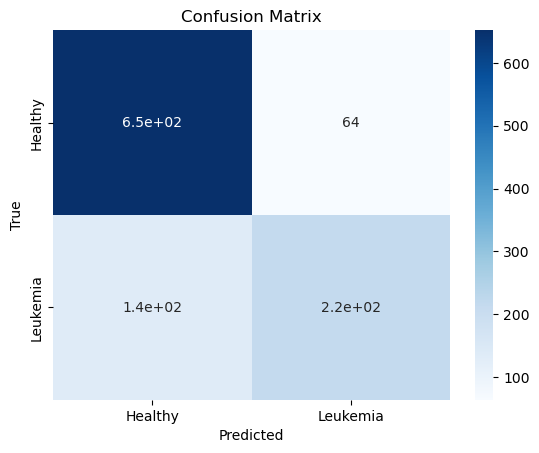

In [110]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

# Assuming you have already trained and tested your model
# Assuming you have already trained and tested your model
y_pred = predict(x_test)
y_true = y_test.argmax(axis=1) # convert true labels to categorical format
cm = confusion_matrix(y_true, y_pred.argmax(axis=1))

# Define labels for the confusion matrix
labels = ['Healthy', 'Leukemia']

# Plot confusion matrix as heatmap with labels
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)

# Display confusion matrix with labels "Healthy" and "Leukemia"
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Fold 10 accuracy: []
